## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_vertical_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/vertical/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


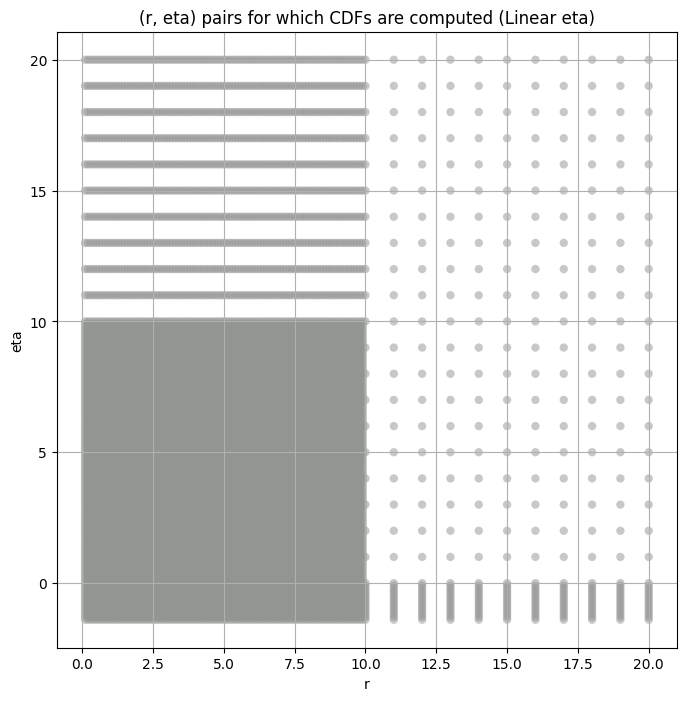

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.351170e+07  1.211205e+07  1.500885e+07   2.246408    1.486038   
3      3.590661e+06  3.372056e+06  3.819214e+06   3.701379    3.151437   
4      7.890078e+05  7.359459e+05  8.446586e+05   5.125396    4.309943   
5      1.749155e+05  1.616798e+05  1.887079e+05   7.056133    5.999982   
6      3.682206e+04  3.364054e+04  4.016611e+04   9.884647    8.382548   
7      7.301948e+03  6.583387e+03  8.069086e+03  13.495996   11.093697   
8      1.585711e+03  1.414825e+03  1.768183e+03  16.748650   13.617682   
9      4.194884e+02  3.735414e+02  4.690611e+02  17.879675   14.476326   

       kurt_upper  total_samples  
layer                             
2        3.200869         2446.0  
3        4.301246         9784.0  
4        6.051431        39136.0  
5        8.277245       156544.0  
6       11.583347       626176.0  
7       16.474209      2504704.0  
8       20.791958     10018816.0  
9       22.065405     40075264.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      1.351170e+07   1.351170e+07    1.051732e+07    8.985504e+06   
3      3.590661e+06   3.590661e+06    3.224329e+06    2.982673e+06   
4      7.890078e+05   7.890078e+05    7.553418e+05    7.314606e+05   
5      1.749155e+05   1.749155e+05    1.708883e+05    1.677571e+05   
6      3.682206e+04   3.682206e+04    3.577543e+04    3.497829e+04   
7      7.301948e+03   7.301948e+03    7.033599e+03    6.837523e+03   
8      1.585711e+03   1.585711e+03    1.518430e+03    1.469379e+03   
9      4.194884e+02   4.194884e+02    4.008074e+02    3.871071e+02   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        7.855378e+06     6.965252e+06     5.610428e+06     4.605138e+06   
3        2.792278e+06     2.633732e+06     2.373431e+06     2.167241e+06   
4        7.111742e+05     6.934434e+05     6.629552e+05     6.362406e+05   
5        1.650202e+05     1.625169e+05     1.580615e+05     1.541586e+05   
6        3.427958e+04     3.364598e+04     3.251646e+04     3.151990e+04   
7        6.669689e+03     6.520051e+03     6.256978e+03     6.028812e+03   
8        1.427478e+03     1.390155e+03     1.325158e+03     1.269341e+03   
9        3.754565e+02     3.651445e+02     3.472953e+02     3.320509e+02   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         3.817344e+06     3.198544e+06     2.677234e+06     1.604672e+06  
3         1.992735e+06     1.841864e+06     1.712226e+06     1.403861e+06  
4         6.123441e+05     5.907271e+05     5.710890e+05     5.203171e+05  
5         1.506198e+05     1.473425e+05     1.442848e+05     1.361338e+05  
6         3.062408e+04     2.980803e+04     2.905208e+04     2.706164e+04  
7         5.825703e+03     5.641657e+03     5.472818e+03     5.037024e+03  
8         1.220131e+03     1.175950e+03     1.135825e+03     1.033675e+03  
9         3.186815e+02     3.067518e+02     2.959697e+02     2.686698e+02

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.009658656716562242 13511695.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.019407580929051982 10517318.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.03036501637888793 8985504.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.04098878275197269 7855378.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.04943179130828577 6965252.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.06842891838356671 5610428.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.08668801019439279 4605138.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.10518498502155284 3817343.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.12083174042586656 3198544.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.1377551769464555 2677234.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.1902695758375926 1604671.8
Number of samples: 2446, Without approximation : 2446.0


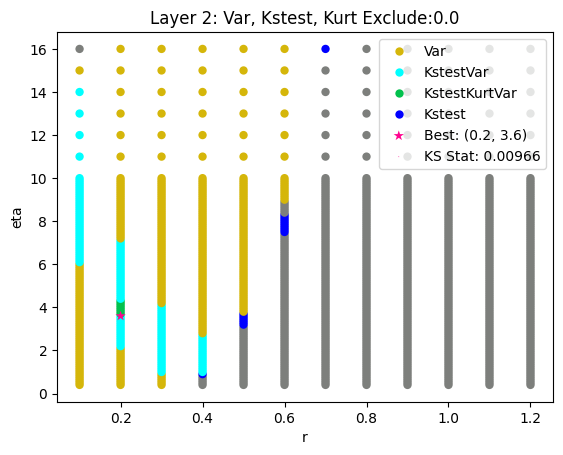

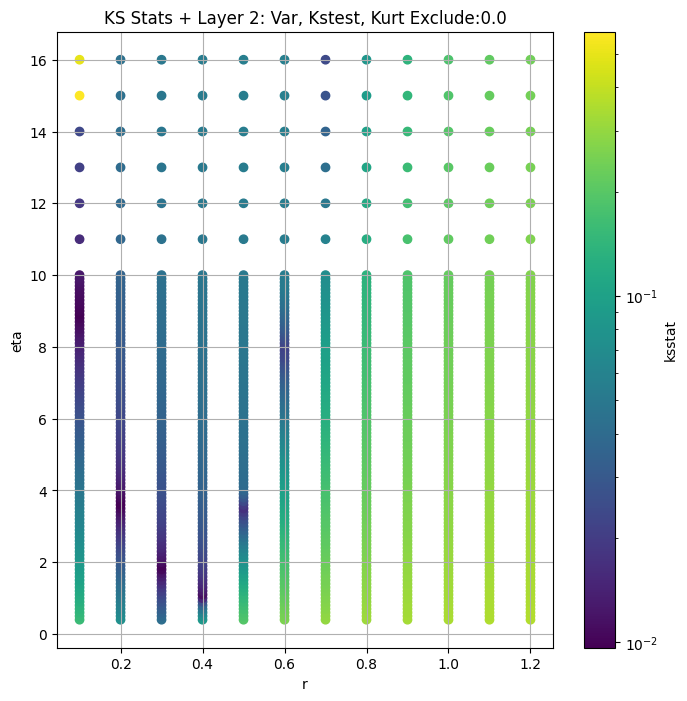

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.011895019923471861 3590661.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.01401406598510957 3224329.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.016729313066175713 2982673.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.019074375563346124 2792278.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.021295019423258177 2633732.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.025536213244891415 2373430.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.03000201443355127 2167241.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.03524621611318198 1992734.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.040671557774784664 1841864.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.045901234701383575 1712226.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.06073865877228856 1403861.4
Number of samples: 9784, Without approximation : 9784.0


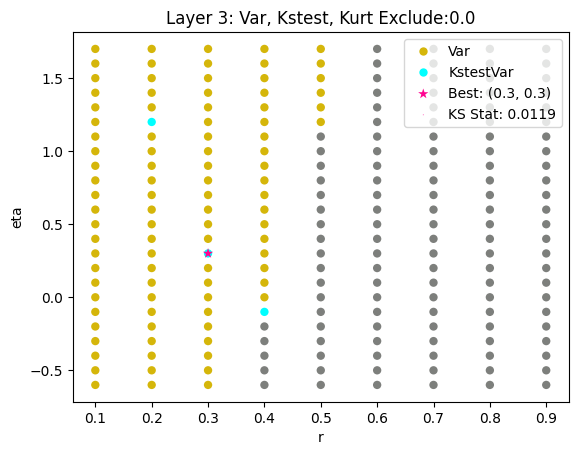

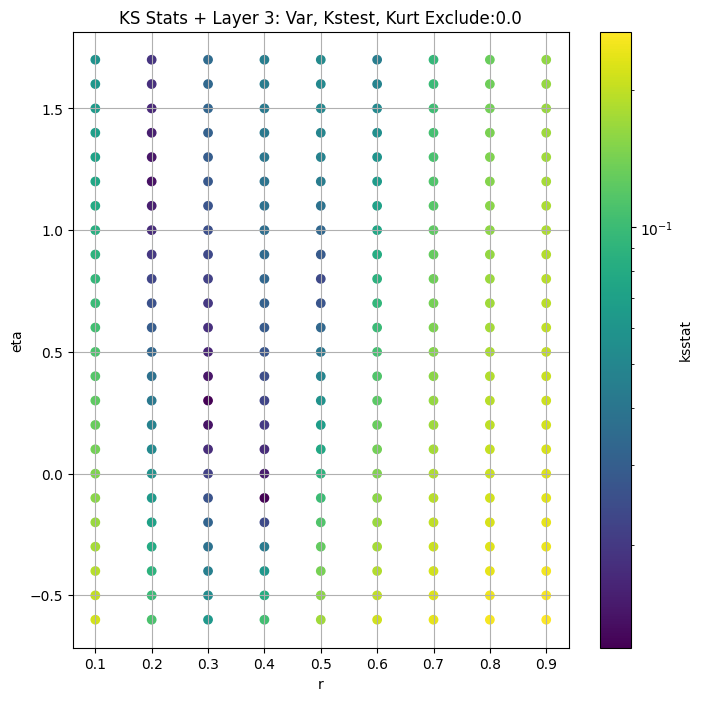

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.012175421647668605 789007.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.015054189467601176 755341.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.01619604406440661 731460.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.015665215354002893 711174.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.017335705235034915 693443.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.018481040029068252 662955.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.019918640653507458 636240.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.019918640653507458 612344.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.02088358750058683 590727.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.023195684250171933 571089.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.0261562371637577 520317.12
Number of samples: 39136, Without approximation : 39136.0


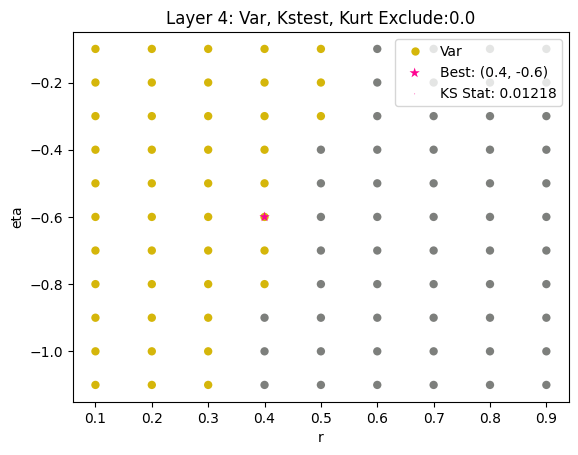

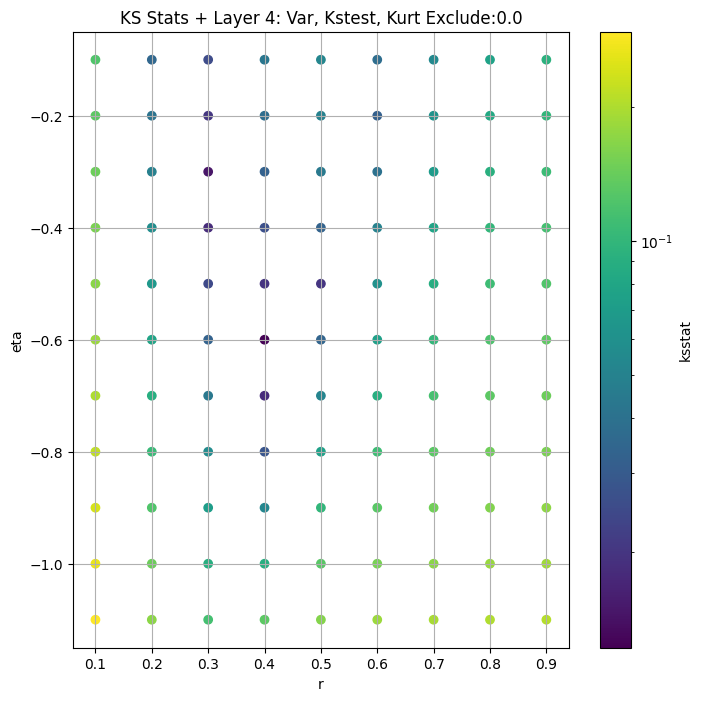

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.008922381695818896 174915.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.010233871124534721 170888.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.011270048095923205 167757.14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.012231399305777421 165020.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.013142455295071215 162516.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.013905777114778028 158061.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.014258589473807648 154158.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.013196880091483787 150619.83


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.013669903659742091 147342.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.014707955180438576 144284.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.017625797084874245 136133.78
Number of samples: 100000, Without approximation : 156544.0


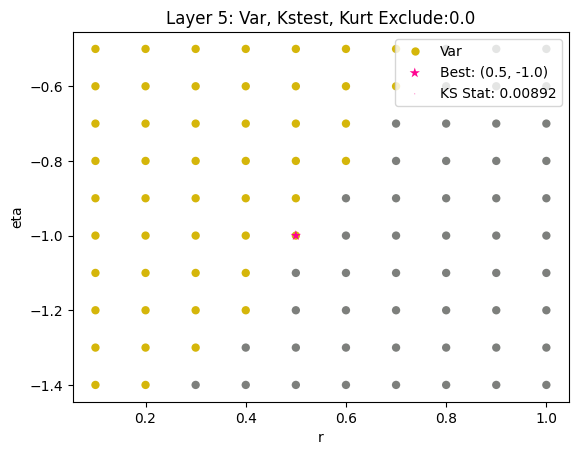

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.012662648330896586 36822.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.011828024450919072 35775.426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.011716196450220873 34978.285


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.011615294195251424 34279.582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.011521285663637859 33645.984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.01241415048793601 32516.457


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.013148579573604713 31519.896


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.01367179859206058 30624.084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.01416612064826217 29808.025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.014640040940910426 29052.078


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.013786130963677423 27061.645
Number of samples: 100000, Without approximation : 626176.0


####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.0203734082324587 7301.948


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.0194591698007478 7033.599


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.01785188740552568 6837.523


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.017674769754875308 6669.6895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.01842714594220557 6520.0513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.018358245684962915 6256.9775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.016752128315588477 6028.8115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.01788895112964911 5825.703


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.016855784445477195 5641.657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.016667217827962877 5472.8184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.016825710271786032 5037.024
Number of samples: 100000, Without approximation : 2504704.0


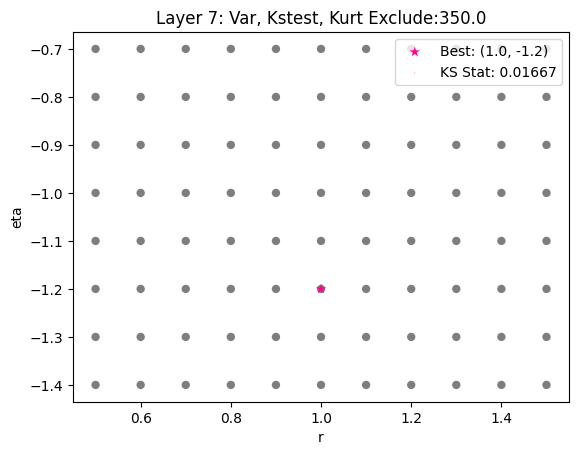

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.008303374769795702 1585.7113


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.009847959938651063 1518.4303


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.011037088413034246 1469.3787


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.012097366224442685 1427.4777


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.011973174035277978 1390.1547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.011234445112235925 1325.1583


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.009914948469744833 1269.3411


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.007576869178135159 1220.1309


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.00693529484766529 1175.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.007823691838712232 1135.8246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010572849300813404 1033.675
Number of samples: 100000, Without approximation : 10018816.0


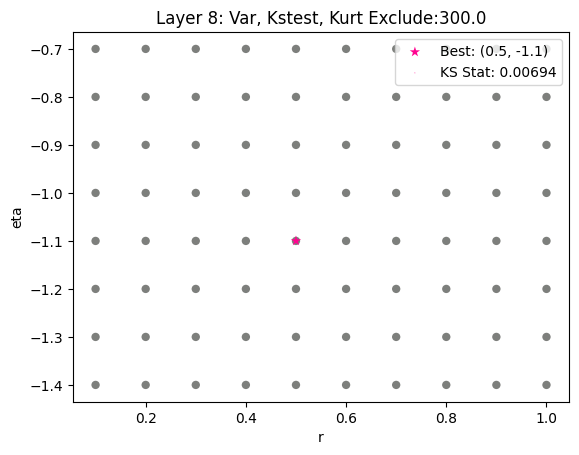

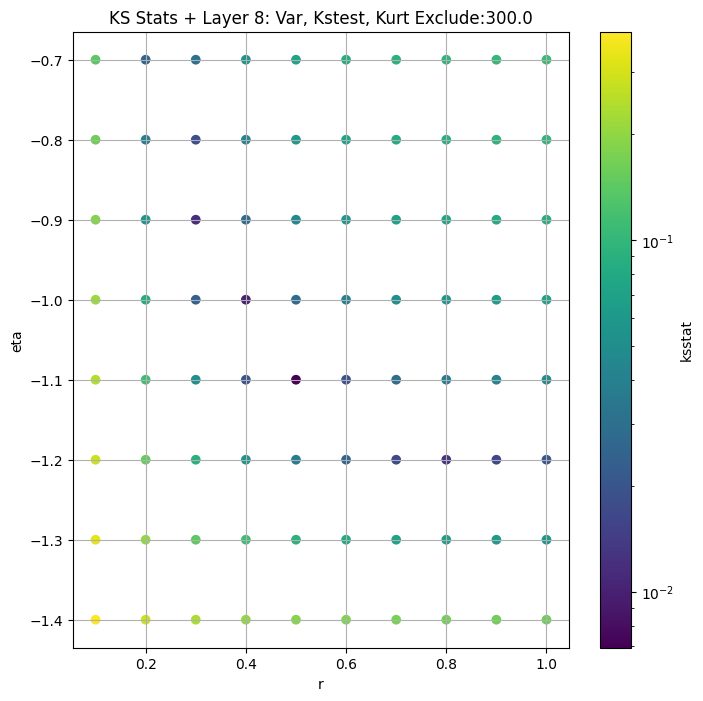

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.014816552065059774 419.4884


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.014459897817256095 400.80737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.014764340059078673 387.10706


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.01504420314743593 375.45654


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.015314066176815633 365.1445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.015824489236146322 347.29526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.01750744193683551 332.05093


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.019823545145312815 318.6815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.020601199258932 306.7518


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.0204417858136115 295.96967


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.01644234104613479 268.66983
Number of samples: 100000, Without approximation : 40075264.0


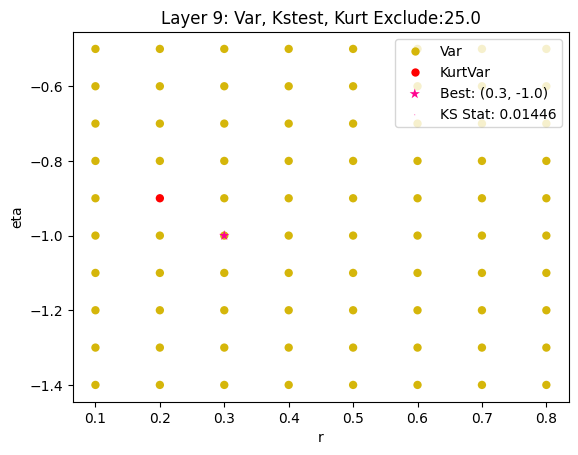

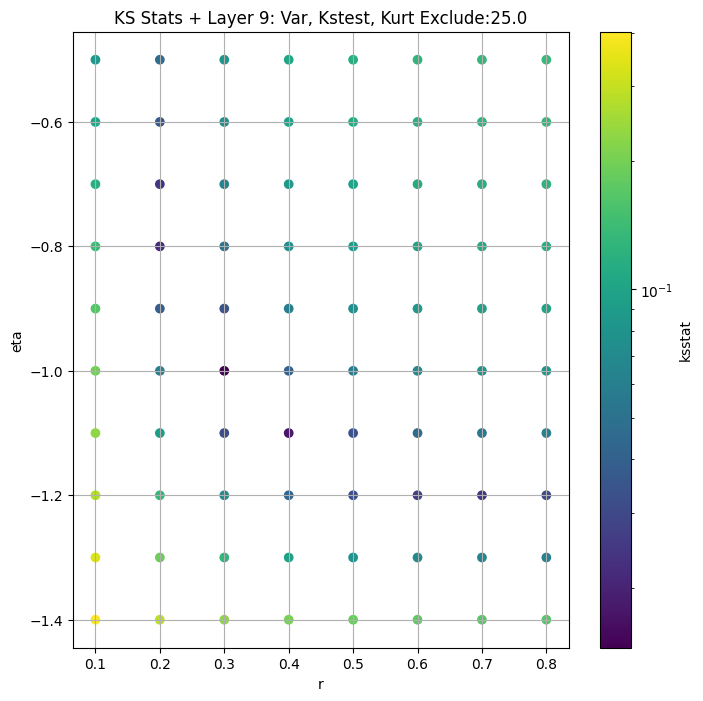

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.351170e+07  1.211205e+07  1.500885e+07   2.246408    1.486038   
3      3.590661e+06  3.372056e+06  3.819214e+06   3.701379    3.151437   
4      7.890078e+05  7.359459e+05  8.446586e+05   5.125396    4.309943   
5      1.749155e+05  1.616798e+05  1.887079e+05   7.056133    5.999982   
6      3.682206e+04  3.364054e+04  4.016611e+04   9.884647    8.382548   
7      7.301948e+03  6.583387e+03  8.069086e+03  13.495996   11.093697   
8      1.585711e+03  1.414825e+03  1.768183e+03  16.748650   13.617682   
9      4.194884e+02  3.735414e+02  4.690611e+02  17.879675   14.476326   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.200869         2446.0             0.009659        0.2          3.6   
3        4.301246         9784.0             0.011895        0.3          0.3   
4        6.051431        39136.0             0.012175        0.4         -0.6   
5        8.277245       156544.0             0.008922        0.5         -1.0   
6       11.583347       626176.0             0.011521        0.4         -1.0   
7       16.474209      2504704.0             0.016667        1.0         -1.2   
8       20.791958     10018816.0             0.006935        0.5         -1.1   
9       22.065405     40075264.0             0.014460        0.3         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.864817                     0.0        1.351170e+07   
3        5201.714801                     0.0        3.590661e+06   
4       53897.091687                     0.0        7.890078e+05   
5       87457.742188                     0.0        1.749155e+05   
6        6895.067486                   100.0        3.364598e+04   
7       18242.727865                   350.0        5.472818e+03   
8         816.631911                   300.0        1.175950e+03   
9          15.076124                    25.0        4.008074e+02   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.052918177055013865, var: 6965252.5


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.04177338316236595, var: 7855378.5


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.03170794836514574, var: 8985504.0


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.019707574511029155, var: 10517318.0


  0%|          | 0/690 [00:00<?, ?it/s]

Finding Minimum after computing 690 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.00949475670692601, var: 13511695.0
Number of samples: 2446, Without approximation : 2446.0


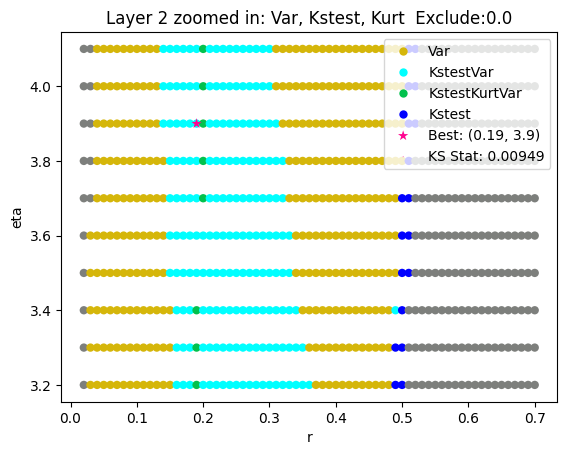

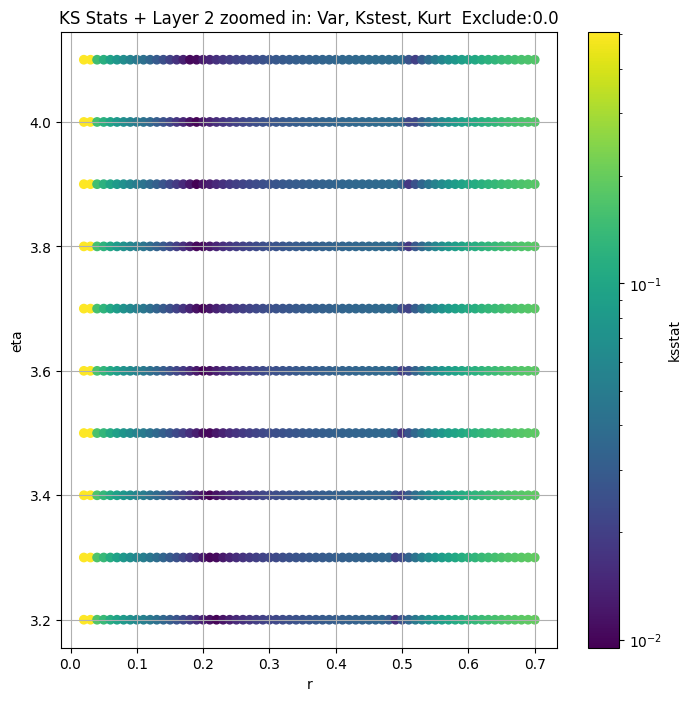

Layer 3


  0%|          | 0/828 [00:00<?, ?it/s]

Finding Minimum after computing 828 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.020778462479062426, var: 2633732.25


  0%|          | 0/828 [00:00<?, ?it/s]

Finding Minimum after computing 828 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.018532929801233666, var: 2792278.5


  0%|          | 0/828 [00:00<?, ?it/s]

Finding Minimum after computing 828 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.016198092812088935, var: 2982673.0


  0%|          | 0/828 [00:00<?, ?it/s]

Finding Minimum after computing 828 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.013961208407059902, var: 3224329.0


  0%|          | 0/828 [00:00<?, ?it/s]

Finding Minimum after computing 828 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.010590632723524118, var: 3590661.0
Number of samples: 9784, Without approximation : 9784.0


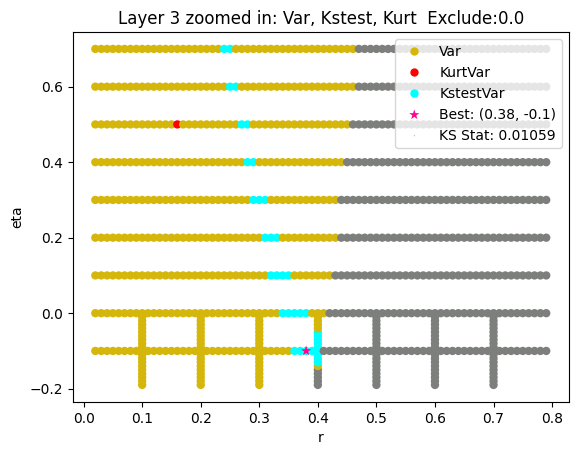

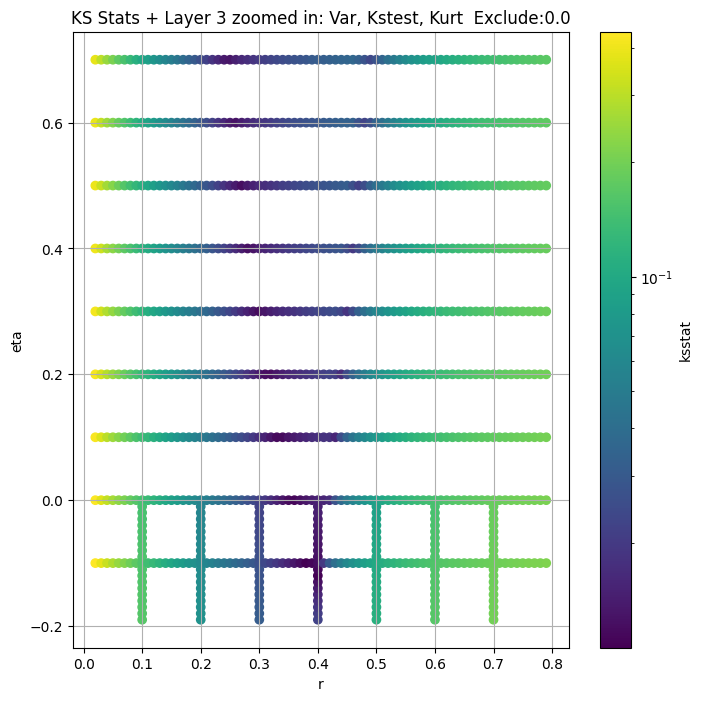

Layer 4


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.0154133768096828, var: 693443.4375


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.014505205704313351, var: 711174.1875


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.014164362951167464, var: 731460.5625


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.013089162475763305, var: 755341.75


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.012175421647668605, var: 789007.8125
Number of samples: 39136, Without approximation : 39136.0


Layer 5


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.010062364068508065, var: 162516.859375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.00965506610822403, var: 165020.1875


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.0092079996712683, var: 167757.140625


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.008676314608508123, var: 170888.34375


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.007661383990142531, var: 174915.484375
Number of samples: 100000, Without approximation : 156544.0


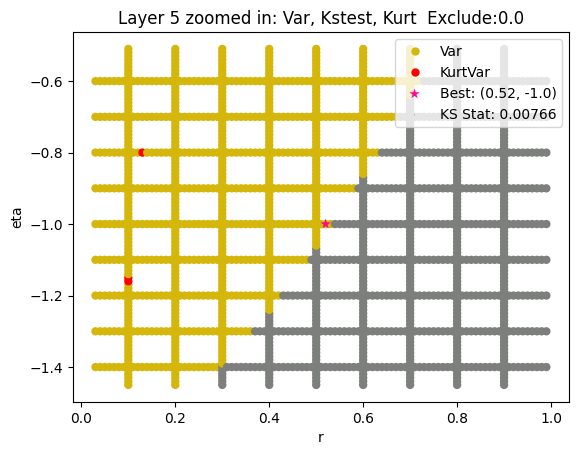

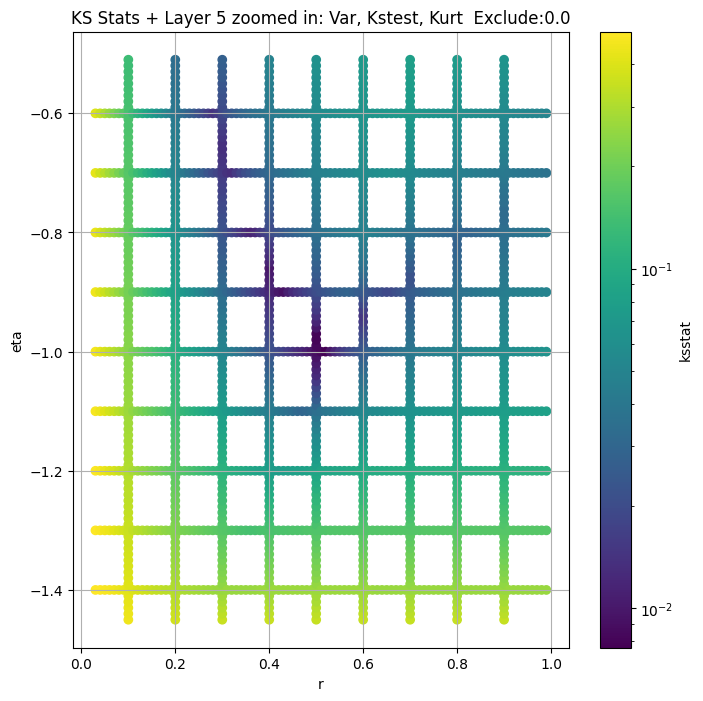

Layer 6


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + 100 = 200, ksstat: 0.011895389108346532, var: 31519.896484375


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + 75 = 175, ksstat: 0.011614975055942445, var: 32003.970703125


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + 50 = 150, ksstat: 0.01132412045697484, var: 32516.45703125


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + 25 = 125, ksstat: 0.011661073619361986, var: 33061.33203125


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + 0 = 100, ksstat: 0.011521285663637859, var: 33645.984375


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + -25 = 75, ksstat: 0.011266707294742218, var: 34279.58203125


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + -50 = 50, ksstat: 0.011132664739110287, var: 34978.28515625


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + -75 = 25, ksstat: 0.01124835198593127, var: 35775.42578125


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 6, 100.0 + -100 = 0, ksstat: 0.011263529638554759, var: 36822.05859375
Number of samples: 100000, Without approximation : 626176.0


Layer 7


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 100 = 450, ksstat: 0.01631655334423837, var: 5172.27490234375


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 75 = 425, ksstat: 0.016291303303498705, var: 5243.28369140625


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 50 = 400, ksstat: 0.01626096738161248, var: 5316.89306640625


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 25 = 375, ksstat: 0.016310878142679452, var: 5393.33984375


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 0 = 350, ksstat: 0.016290524182271504, var: 5472.818359375


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -25 = 325, ksstat: 0.016246013612713106, var: 5555.5


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -50 = 300, ksstat: 0.016255922082248242, var: 5641.6572265625


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -75 = 275, ksstat: 0.016356239047673193, var: 5731.59912109375


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -100 = 250, ksstat: 0.01647250791383198, var: 5825.703125
Number of samples: 100000, Without approximation : 2504704.0


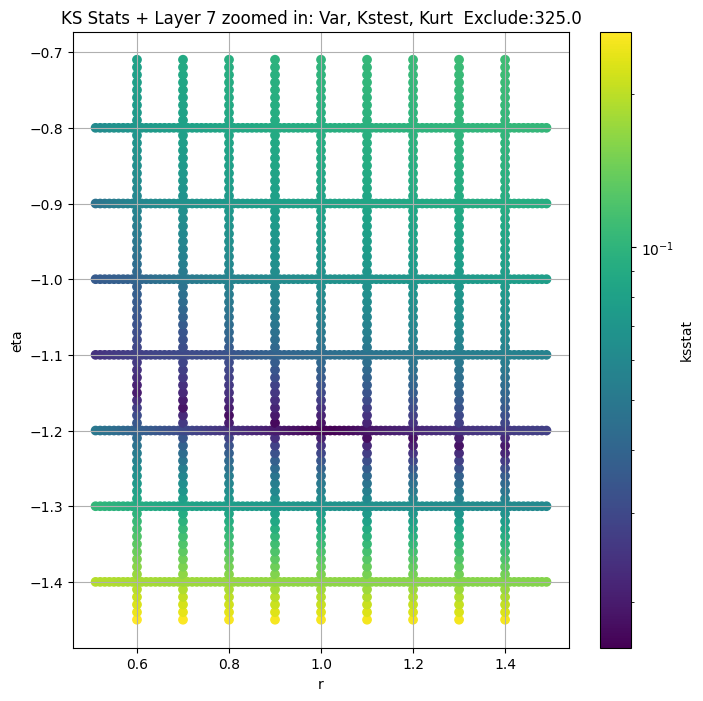

Layer 8


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + 100 = 400, ksstat: 0.007801011920909366, var: 1099.052734375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + 75 = 375, ksstat: 0.0074083416276272095, var: 1117.048583984375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + 50 = 350, ksstat: 0.007262053322609985, var: 1135.8245849609375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + 25 = 325, ksstat: 0.007098151193684843, var: 1155.4324951171875


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + 0 = 300, ksstat: 0.006805768297433734, var: 1175.949951171875


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + -25 = 275, ksstat: 0.0064891560384420545, var: 1197.48291015625


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + -50 = 250, ksstat: 0.006105007154817599, var: 1220.130859375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + -75 = 225, ksstat: 0.005836670044192114, var: 1244.0294189453125


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 300.0 + -100 = 200, ksstat: 0.005433251143580453, var: 1269.341064453125
Number of samples: 100000, Without approximation : 10018816.0


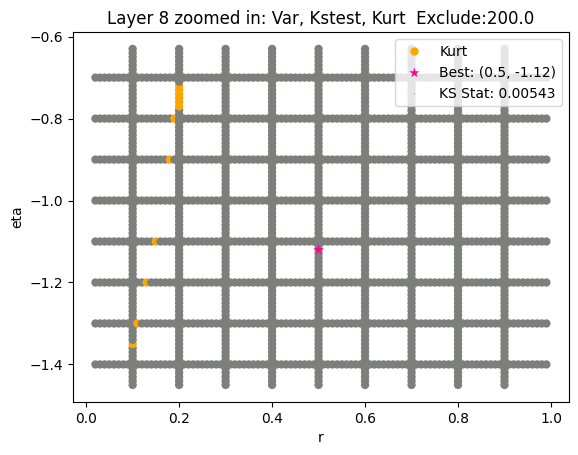

Layer 9


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.014073034197683298, var: 355.8274841308594


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.014301977380314246, var: 365.1445007324219


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.014107294829105332, var: 375.45654296875


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.014521174927091152, var: 387.1070556640625


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.014459897817256095, var: 400.807373046875


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.013692817513055455, var: 419.4884033203125
Number of samples: 100000, Without approximation : 40075264.0


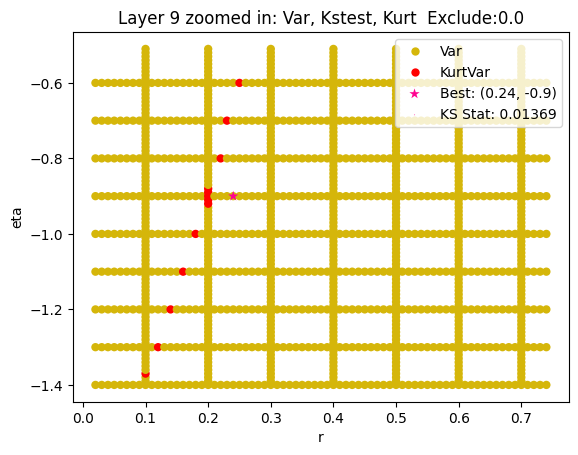

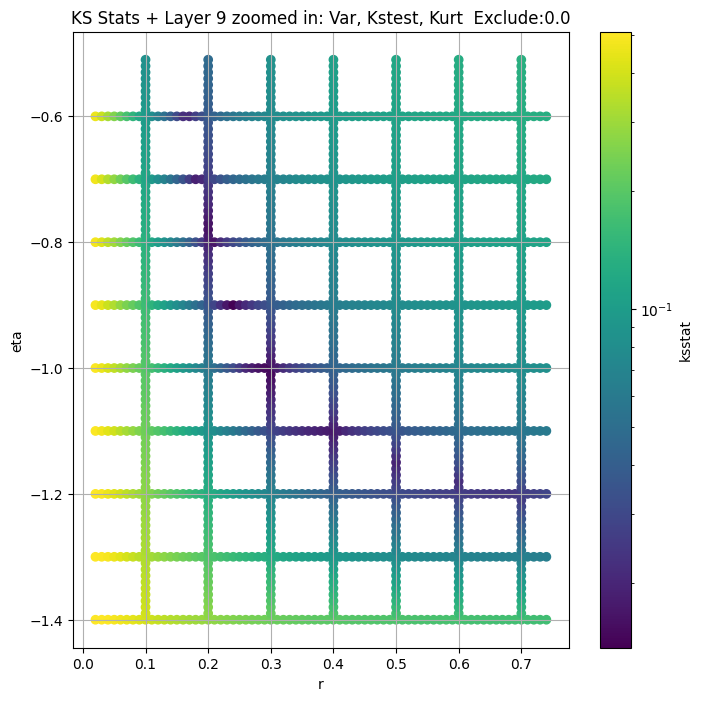

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.351170e+07  1.211205e+07  1.500885e+07   2.246408    1.486038   
3      3.590661e+06  3.372056e+06  3.819214e+06   3.701379    3.151437   
4      7.890078e+05  7.359459e+05  8.446586e+05   5.125396    4.309943   
5      1.749155e+05  1.616798e+05  1.887079e+05   7.056133    5.999982   
6      3.682206e+04  3.364054e+04  4.016611e+04   9.884647    8.382548   
7      7.301948e+03  6.583387e+03  8.069086e+03  13.495996   11.093697   
8      1.585711e+03  1.414825e+03  1.768183e+03  16.748650   13.617682   
9      4.194884e+02  3.735414e+02  4.690611e+02  17.879675   14.476326   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.200869         2446.0             0.009659        0.2          3.6   
3        4.301246         9784.0             0.011895        0.3          0.3   
4        6.051431        39136.0             0.012175        0.4         -0.6   
5        8.277245       156544.0             0.008922        0.5         -1.0   
6       11.583347       626176.0             0.011521        0.4         -1.0   
7       16.474209      2504704.0             0.016667        1.0         -1.2   
8       20.791958     10018816.0             0.006935        0.5         -1.1   
9       22.065405     40075264.0             0.014460        0.3         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.864817                     0.0        1.351170e+07   
3        5201.714801                     0.0        3.590661e+06   
4       53897.091687                     0.0        7.890078e+05   
5       87457.742188                     0.0        1.749155e+05   
6        6895.067486                   100.0        3.497829e+04   
7       18242.727865                   350.0        5.555500e+03   
8         816.631911                   300.0        1.269341e+03   
9          15.076124                    25.0        4.194884e+02   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.009495    0.19      3.90   
3                     0.013713          0.010591    0.38     -0.10   
4                     0.006861          0.012175    0.40     -0.60   
5                     0.003431          0.007661    0.52     -1.00   
6                     0.001716          0.011133    0.40     -1.01   
7                     0.000858          0.016246    1.00     -1.20   
8                     0.000429          0.005433    0.50     -1.12   
9                     0.000215          0.013693    0.24     -0.90   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2          0.207680                  0.0        20892  
3      70854.924244                  0.0        16510  
4      53897.091687                  0.0        12382  
5      99325.482929                  0.0        33021  
6       7427.369893                 50.0        14676  
7      18518.333333                325.0         7338  
8        948.969097                200.0        66042  
9          1.433401                  0.0         9784

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

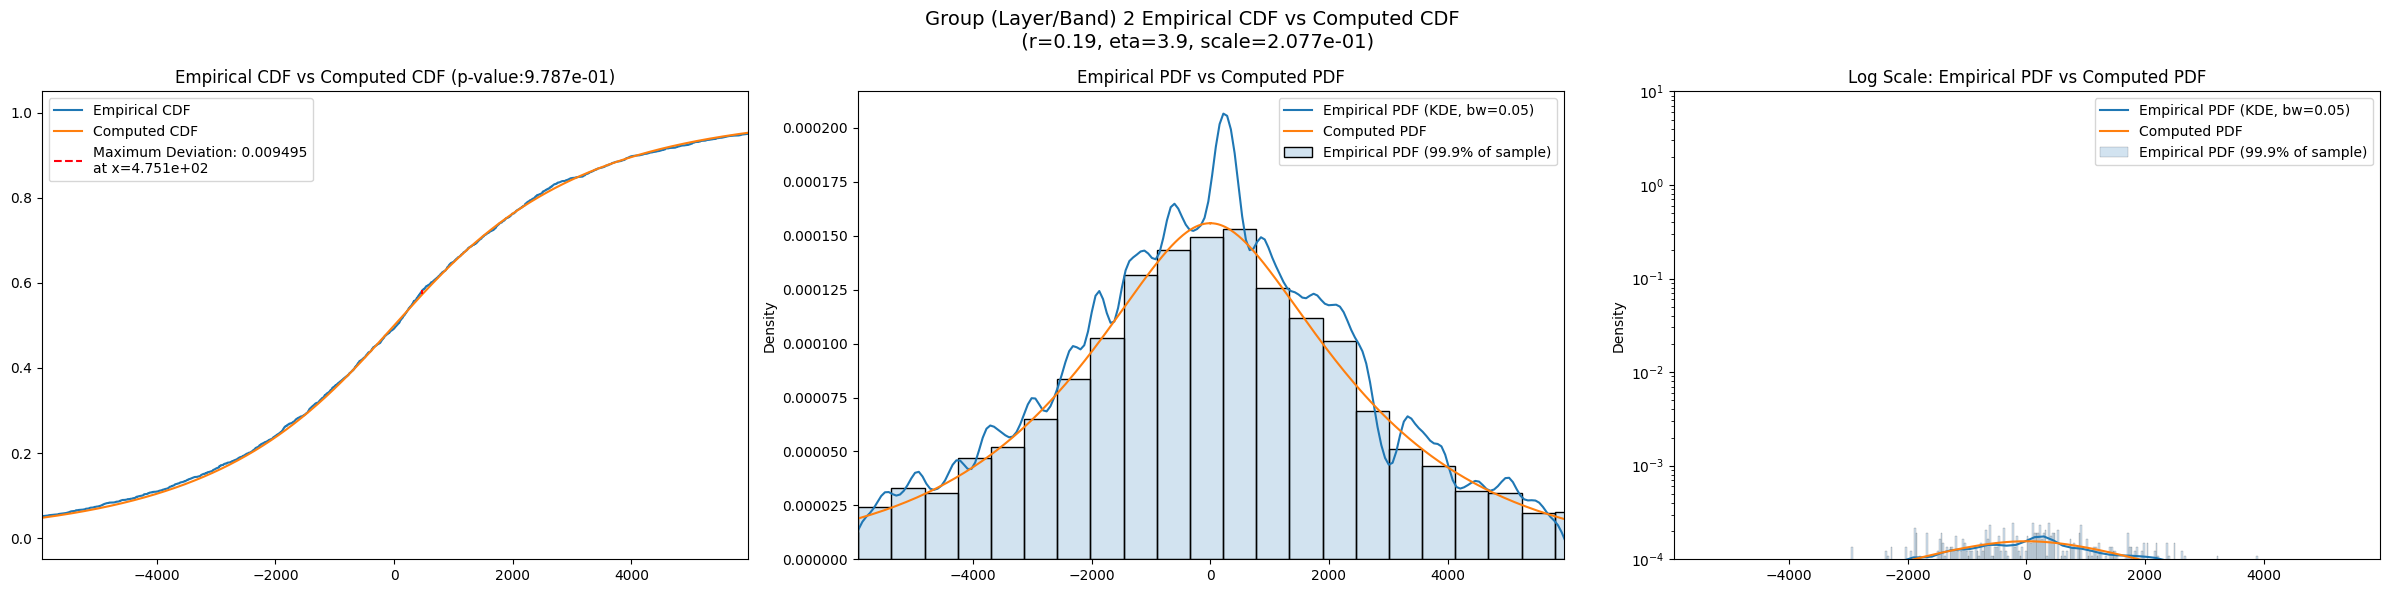

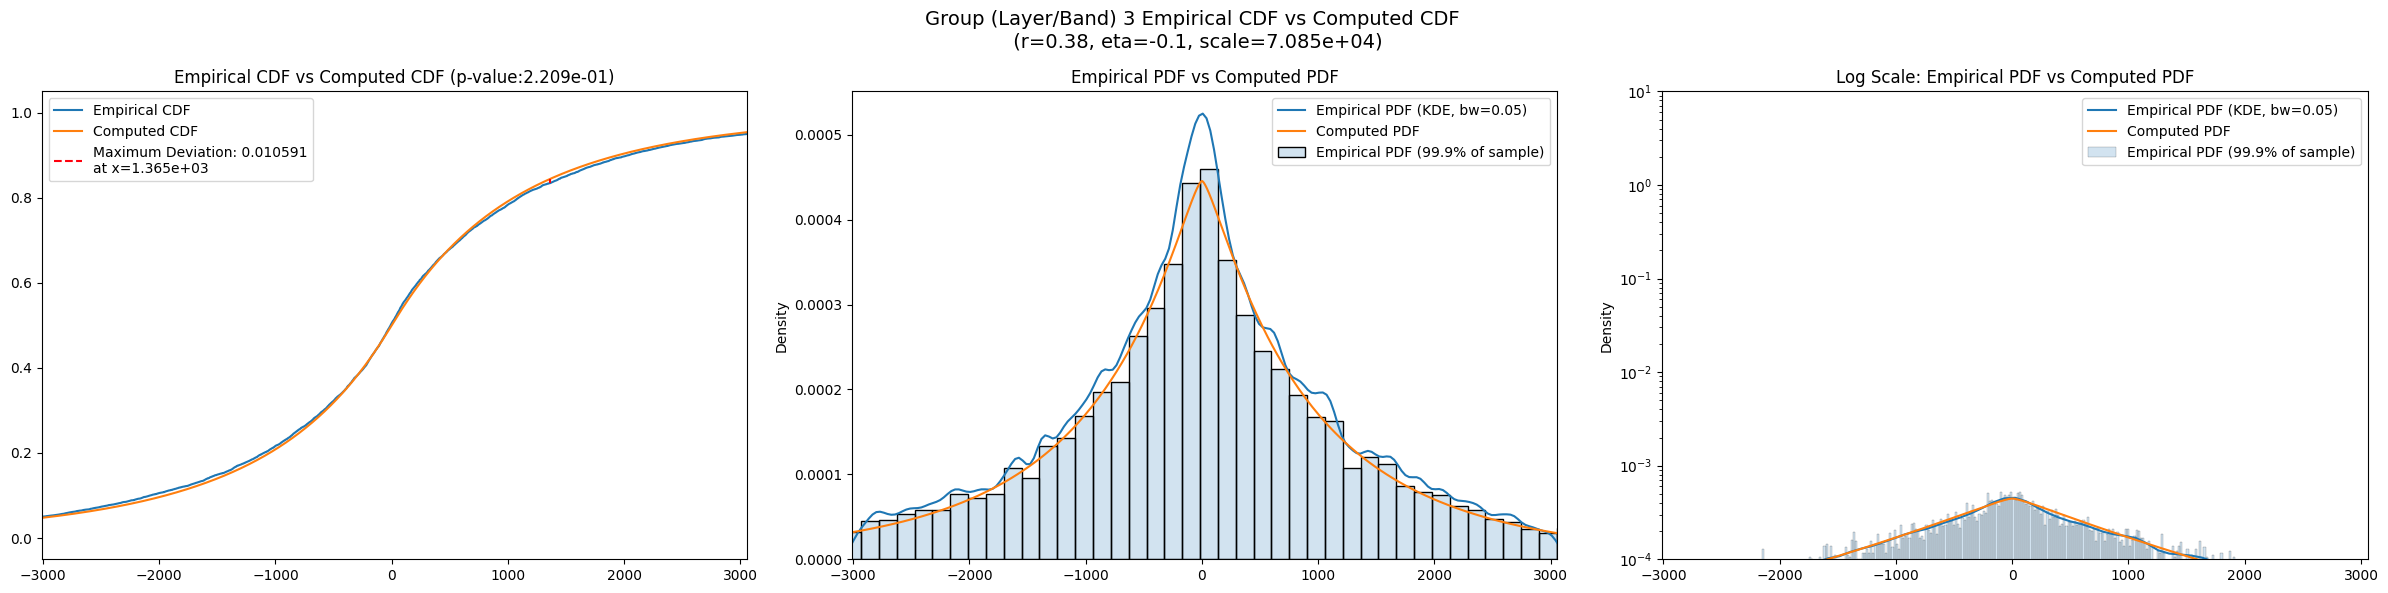

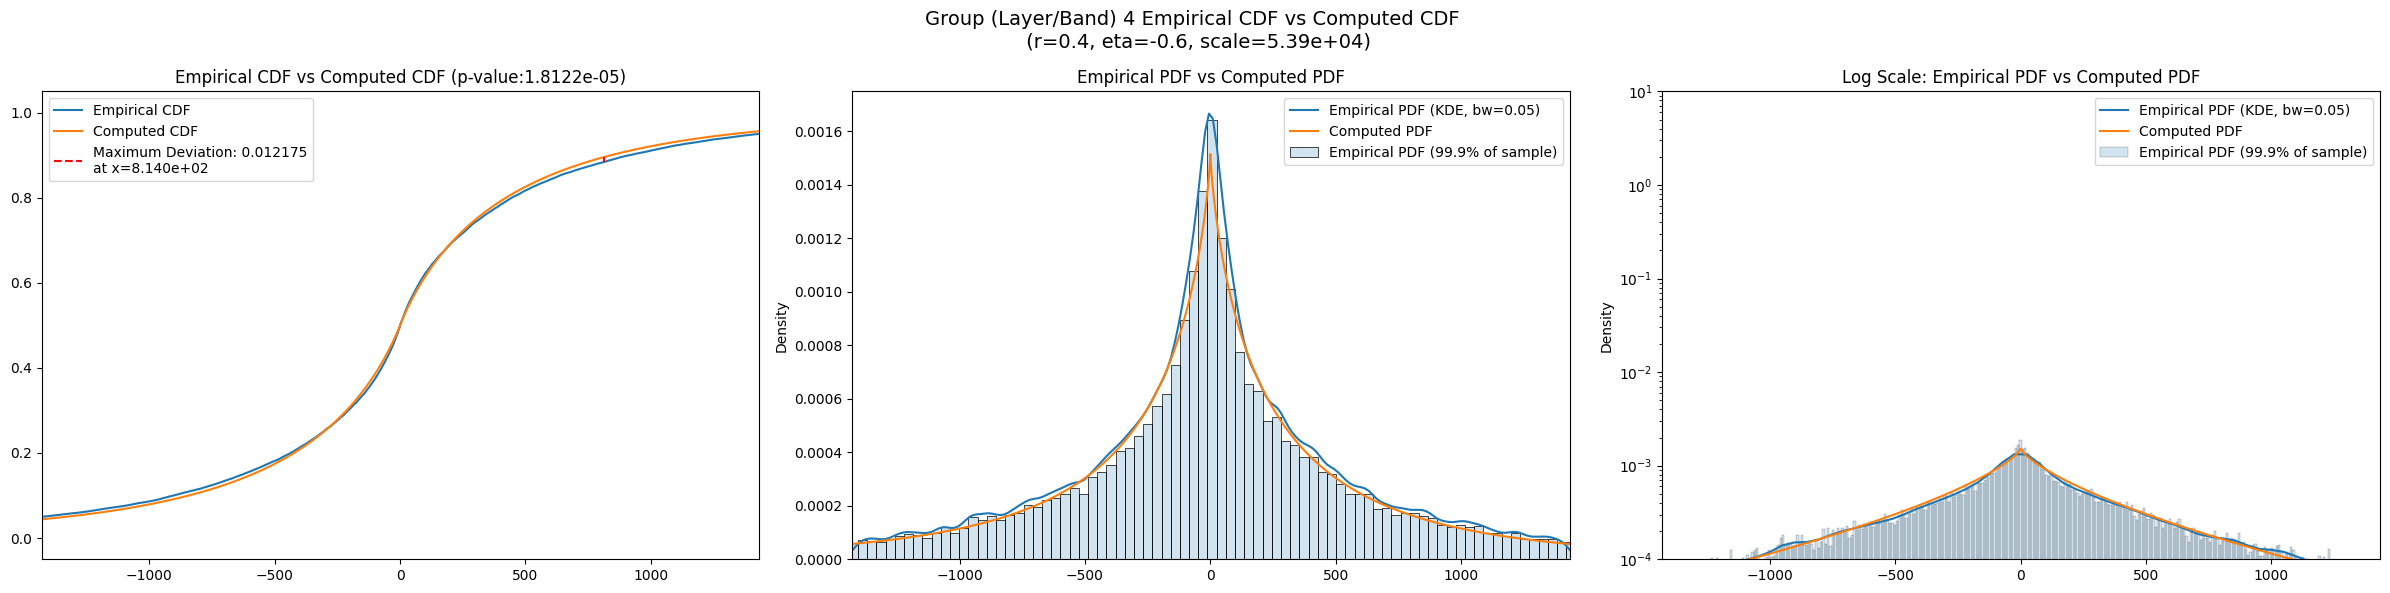

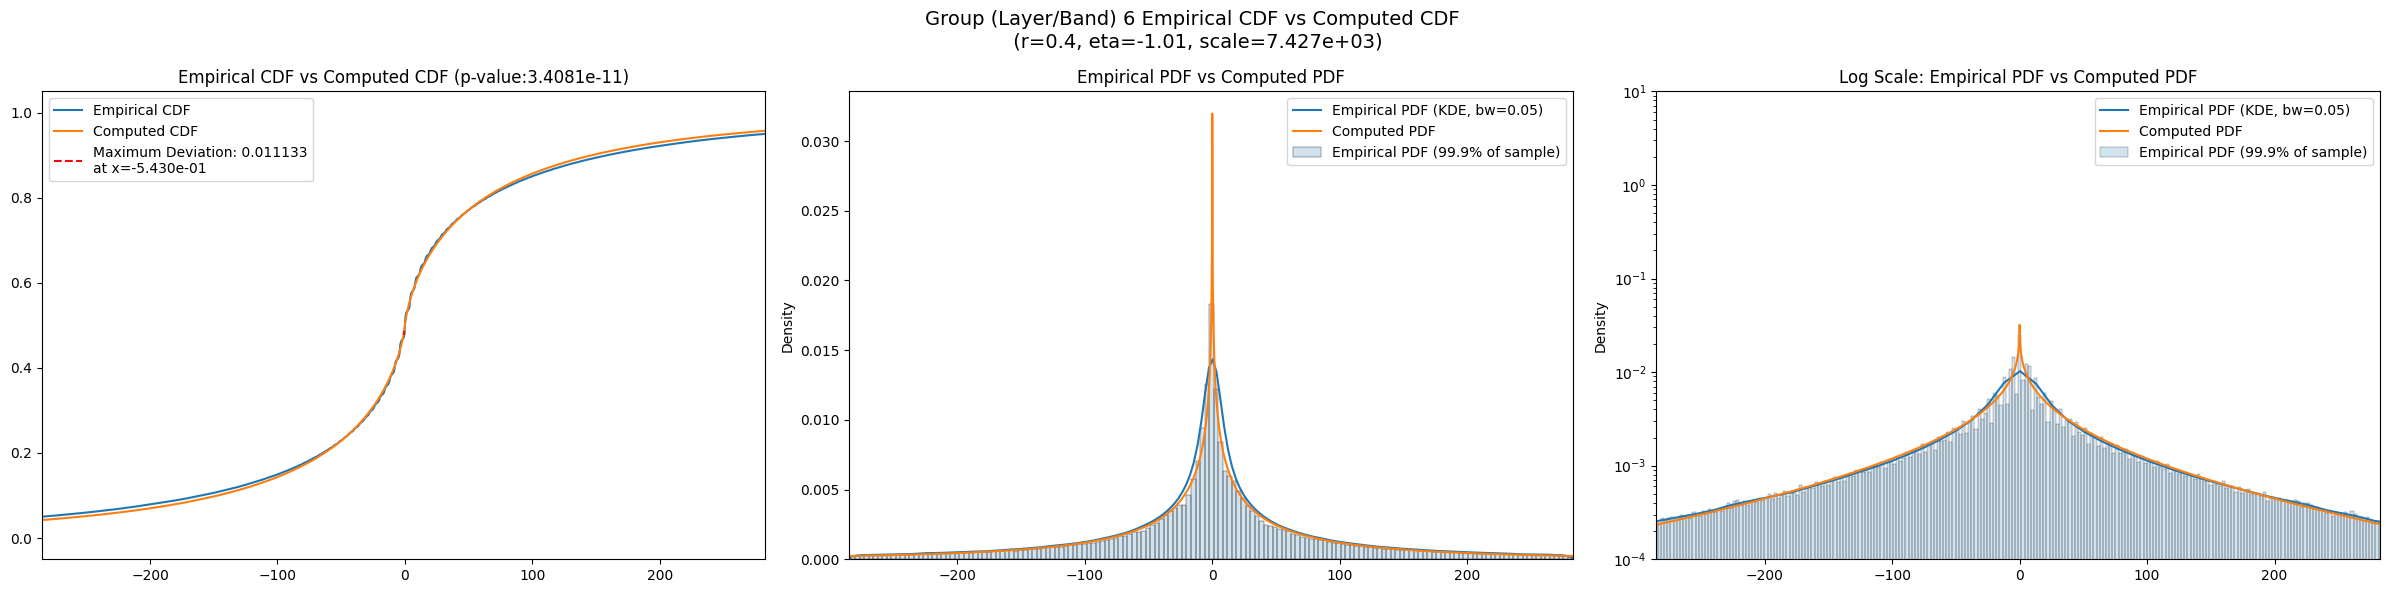

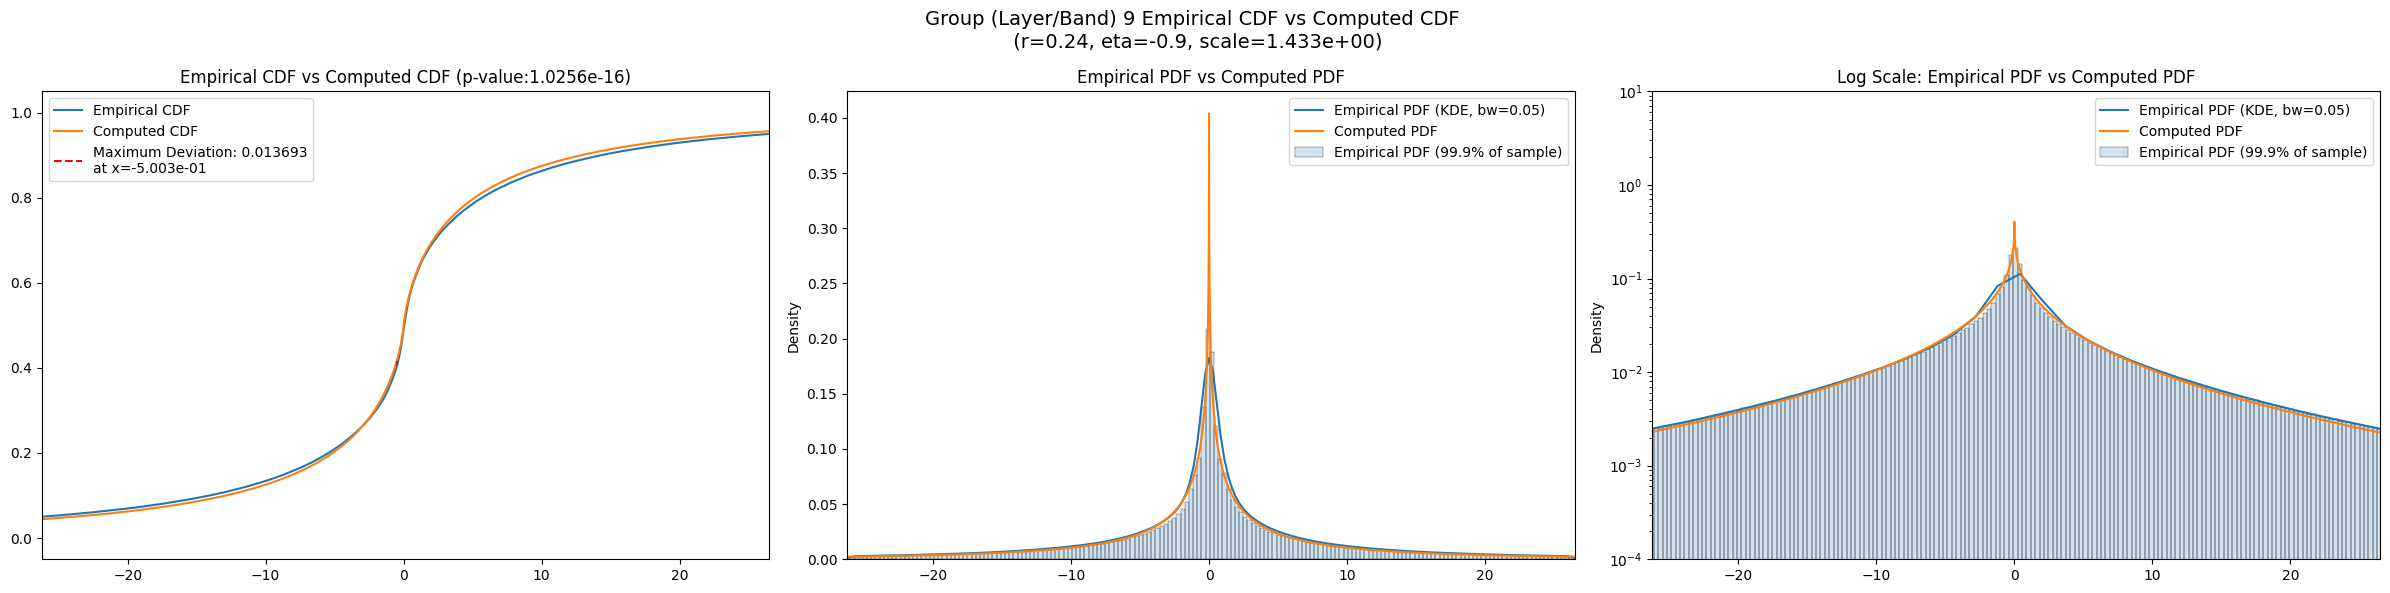

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      1.351170e+07  1.211205e+07  1.500885e+07   2.246408    1.486038   
3      3.590661e+06  3.372056e+06  3.819214e+06   3.701379    3.151437   
4      7.890078e+05  7.359459e+05  8.446586e+05   5.125396    4.309943   
5      1.749155e+05  1.616798e+05  1.887079e+05   7.056133    5.999982   
6      3.682206e+04  3.364054e+04  4.016611e+04   9.884647    8.382548   
7      7.301948e+03  6.583387e+03  8.069086e+03  13.495996   11.093697   
8      1.585711e+03  1.414825e+03  1.768183e+03  16.748650   13.617682   
9      4.194884e+02  3.735414e+02  4.690611e+02  17.879675   14.476326   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.200869         2446.0             0.009659        0.2          3.6   
3        4.301246         9784.0             0.011895        0.3          0.3   
4        6.051431        39136.0             0.012175        0.4         -0.6   
5        8.277245       156544.0             0.008922        0.5         -1.0   
6       11.583347       626176.0             0.011521        0.4         -1.0   
7       16.474209      2504704.0             0.016667        1.0         -1.2   
8       20.791958     10018816.0             0.006935        0.5         -1.1   
9       22.065405     40075264.0             0.014460        0.3         -1.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      3128.39000              0.026220          6.803550e-02   
3      ...      1370.76000              0.040059          4.443860e-14   
4      ...       544.08000              0.056920         1.177040e-110   
5      ...       213.91600              0.068355          0.000000e+00   
6      ...        80.00600              0.077539          0.000000e+00   
7      ...        31.97370              0.078243          0.000000e+00   
8      ...        14.50520              0.074358          0.000000e+00   
9      ...         6.62329              0.085433          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         2686.46000             0.014058         7.135350e-01  2234.91000   
3         1180.53000             0.014752         2.801740e-02   966.42300   
4          470.23800             0.030354         9.223750e-32   378.76700   
5          184.36900             0.042478        6.919080e-246   145.32200   
6           68.70420             0.052674         0.000000e+00    53.28910   
7           27.40990             0.053590         0.000000e+00    21.29360   
8           12.59690             0.048983         0.000000e+00     9.71055   
9            5.64882             0.060894         0.000000e+00     4.39182   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.014054   7.138800e-01          9.786965e-01  
3           0.020128   7.111730e-04          2.208995e-01  
4           0.034297   1.971760e-40          1.812175e-05  
5           0.044361  3.915510e-268          2.077658e-08  
6           0.053916   0.000000e+00          7.733127e-68  
7           0.053898   0.000000e+00          0.000000e+00  
8           0.049360   0.000000e+00         2.556475e-257  
9           0.062384   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.009659                 0.027391          0.009495   
3                 0.011895                 0.013713          0.010591   
4                 0.012175                 0.006861          0.012175   
5                 0.008922                 0.003431          0.007661   
6                 0.011521                 0.001716          0.011133   
7                 0.016667                 0.000858          0.016246   
8                 0.006935                 0.000429          0.005433   
9                 0.014460                 0.000215          0.013693   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.026220             0.014058       0.014054  
3                  0.040059             0.014752       0.020128  
4                  0.056920             0.030354       0.034297  
5                  0.068355             0.042478       0.044361  
6                  0.077539             0.052674       0.053916  
7                  0.078243             0.053590       0.053898  
8                  0.074358             0.048983       0.049360  
9                  0.085433             0.060894       0.062384

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            1.351170e+07          0.009495    0.19      3.90      0.207680   
3            3.590661e+06          0.010591    0.38     -0.10  70854.924244   
4            7.890078e+05          0.012175    0.40     -0.60  53897.091687   
5            1.749155e+05          0.007661    0.52     -1.00  99325.482929   
6            3.497829e+04          0.011133    0.40     -1.01   7427.369893   
7            5.555500e+03          0.016246    1.00     -1.20  18518.333333   
8            1.269341e+03          0.005433    0.50     -1.12    948.969097   
9            4.194884e+02          0.013693    0.24     -0.90      1.433401   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                     50.0  
7                    325.0  
8                    200.0  
9                      0.0

In [21]:
eng.quit()